# Check 3D pdf learned by NN

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import jax.random as rjax
import flax
from flax import nn, optim, serialization
import matplotlib.pyplot as plt

In [2]:
from lib.params import mdn, mdstp, mpip

In [3]:
import matplotlib.pyplot as plt

In [4]:
from glob import glob
import os
import re

In [5]:
smeared_fname = re.compile(r'.+_gs(\d+\.\d+)_(\d\.\d+)_ch(\d+)_smeared\.npy')

In [6]:
def find_smeared(path):
    return glob(os.path.join(path, '*_smeared.npy'))

In [7]:
fnames = find_smeared('mcsamples')
fnames[:3]

['mcsamples/mc_ddpip_3d_gs35.00_1.90_ch250_smeared.npy',
 'mcsamples/mc_ddpip_3d_gs46.00_1.30_ch250_smeared.npy',
 'mcsamples/mc_ddpip_3d_gs46.50_1.85_ch250_smeared.npy']

In [9]:
mc = np.load('mcsamples/mc_ddpip_3d_gs40.10_1.61_ch1500_smeared.npy')[:3*10**5]
mc.shape

(300000, 3)

In [10]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [11]:
mcvars = get_vars(mc)

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
def draw_1d_projections(ax, data, bins=250, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for idx, lbl in enumerate(labels):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights);
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [13]:
def hist_2d(x, y, rng=None, bins=50, weights=None):
    hist, xbins, ybins = onp.histogram2d(x, y, bins=bins, range=rng, weights=weights)
    xbins = 0.5 * (xbins[:-1] + xbins[1:])
    ybins = 0.5 * (ybins[:-1] + ybins[1:])
    xv, yv = onp.meshgrid(xbins, ybins)
    return (xv, yv, hist.T)

In [14]:
def put_contours(ax, x, y, bins=20, levels=6, weights=None):
    ax.contourf(*hist_2d(x=x, y=y, rng=None, bins=[bins,bins], weights=weights), levels=levels)

In [15]:
def draw_2d_projections(ax, data, bins=20, levels=6, weights=None):
    for idx, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        put_contours(ax[idx], data[:,i], data[:,j], bins, levels, weights)
        ax[idx].grid()

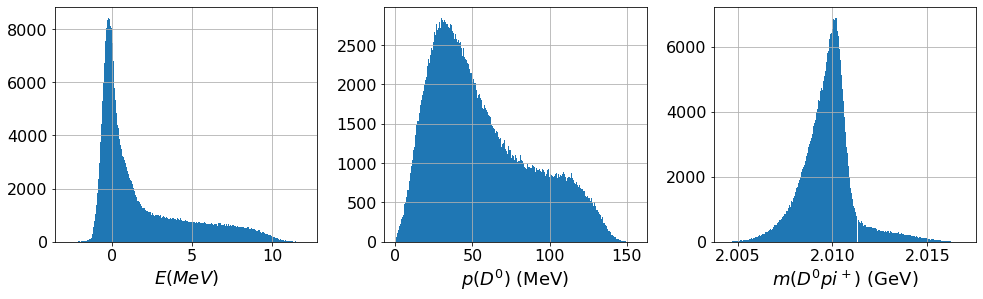

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4.5))
draw_1d_projections(ax, mcvars)
fig.tight_layout()

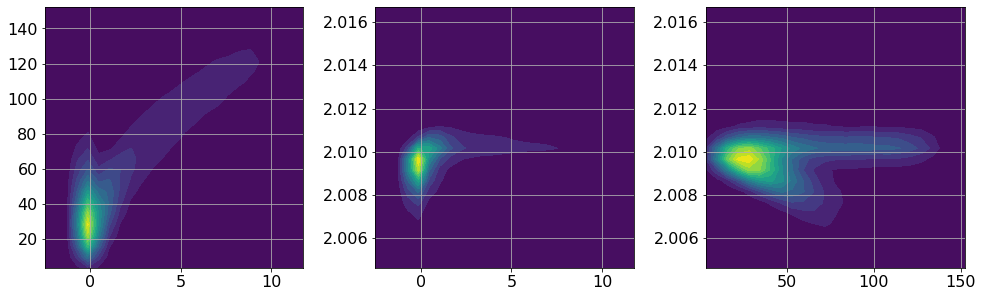

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4.5))
draw_2d_projections(ax, mcvars, bins=25, levels=15)
fig.tight_layout()

In [18]:
def normalize(data):
    means = [np.mean(data[:,i]) for i in range(3)]
    stds = [np.std(data[:,i]) for i in range(3)]
    newdata = np.column_stack([(data[:, i] - means[i]) / stds[i] for i in range(3)])
    return (newdata, means, stds)

In [19]:
mcvars_norm, norm_mean, norm_std = normalize(mcvars)
norm_mean, norm_std

([DeviceArray(1.8590932, dtype=float32),
  DeviceArray(56.122078, dtype=float32),
  DeviceArray(2.0097547, dtype=float32)],
 [DeviceArray(2.8228464, dtype=float32),
  DeviceArray(32.606438, dtype=float32),
  DeviceArray(0.00137304, dtype=float32)])

In [20]:
mcvars_norm[:,0].mean(), mcvars_norm[:,0].std()

(DeviceArray(-6.866876e-08, dtype=float32), DeviceArray(1., dtype=float32))

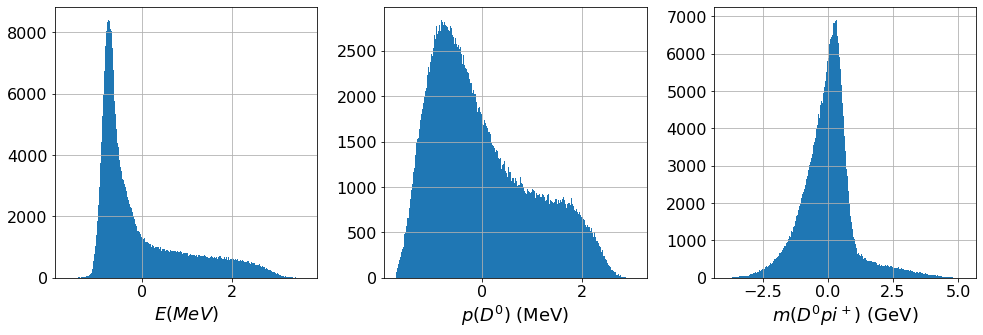

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(14,5))
draw_1d_projections(ax, mcvars_norm)
fig.tight_layout()

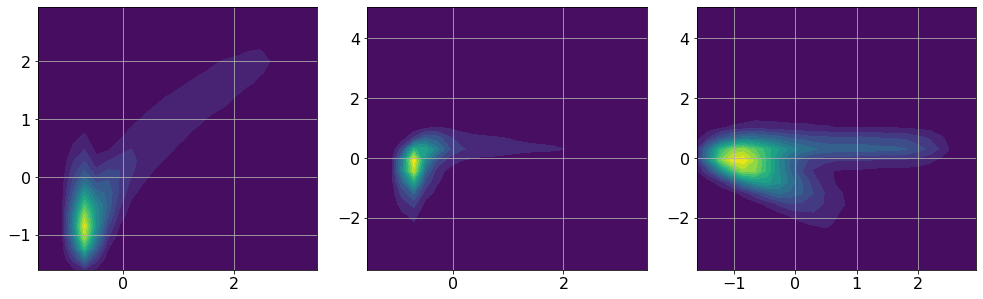

In [22]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4.5))
draw_2d_projections(ax, mcvars_norm, bins=25, levels=15)
fig.tight_layout()

In [23]:
train_frac = 0.8
train_edge = int(mcvars_norm.shape[0]*train_frac)
mc_train, mc_test = mcvars_norm[:train_edge], mcvars_norm[train_edge:]
mc_train.shape, mc_test.shape

((236474, 3), (59119, 3))

In [24]:
mc_train = mc_train[:2*10**5]
mc_test = mc_test[:5*10**4]
mc_train.shape, mc_test.shape

((200000, 3), (50000, 3))

Load NN model

In [25]:
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer

In [26]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=16)
        x = nn.relu(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)

In [27]:
def do_fit(data, epochs=100, lbl='', test_data=None, l2lambda=None, batch_size=5*10**4, norm_size=4*10**5,
           learning_rate=0.001):
    """ """
    test_data_provided = test_data is not None
    l2_norm_turned_on = l2lambda is not None

    # Initialize the model
    _, initial_params = NN.init(rjax.PRNGKey(0), data)
    print('Model initialized:')
    print(jax.tree_map(np.shape, initial_params))
    
    # Generate normalization sample
    norm_space = (
        (data[:,0].min(), data[:,0].max()),
        (data[:,1].min(), data[:,1].max()),
        (data[:,2].min(), data[:,2].max()),
    )

    rng = rjax.PRNGKey(10)
    rng, *keys = rjax.split(rng, 4)
    
    norm_sample = np.column_stack([
        rjax.uniform(rjax.PRNGKey(key[0]), (norm_size,), minval=lo, maxval=hi)\
            for key, (lo, hi) in zip(keys, norm_space)
    ])
    
    # Define L2 norm
    def l2_loss(model, lmbd):
        return lmbd * sum(map(lambda l: np.sum(l[1]['kernel']**2), model.params.items()))

    if l2lambda is None:
        l2norm = lambda m: 0
    else:
        l2norm = lambda m: l2_loss(m, l2lambda)
    
    # Define loglh loss function
    def loglh_loss(model, evts):
        """ loss function for the unbinned maximum likelihood fit """
        return -np.sum(np.log(model(evts))) +\
            evts.shape[0] * (
                np.log(np.mean(model(norm_sample))) +\
                l2norm(model)
            )

    # Adam minimizer
    model = nn.Model(NN, initial_params)
    adam = optim.Adam(learning_rate=learning_rate)
    optimizer = adam.create(model)

    history = {'loss': []}
    if test_data_provided:
        history['test_loss'] = []

    num_batches = data.shape[0] // batch_size + 1
    if data.shape[0] % batch_size == 0:
        num_batches -= 1
        
    for epoch in range(epochs):
        print(f'epoch {epoch:3d}/{epochs:<4d}')
        print(f'  {num_batches} batches: ', end='')
        for ibatch in range(num_batches):
            print(f'{ibatch+1}', end=' ')
            
            batch = data[ibatch*batch_size:(ibatch+1)*batch_size]
            batch_loss_fcn = lambda model: loglh_loss(model, batch)

            _, grad = jax.value_and_grad(batch_loss_fcn)(optimizer.target)
            optimizer = optimizer.apply_gradient(grad)
        print('')

        train_loss = loglh_loss(optimizer.target, data)
        history['loss'].append(train_loss)
        if test_data_provided:
            test_loss = loglh_loss(optimizer.target, test_data)
            history['test_loss'].append(test_loss)
            print(f'{epoch:4d}/{epochs:<4d} loss: {train_loss:<12.3f}\t tloss: {test_loss:<12.3f}')
        else:
            print(f'{epoch:4d}/{epochs:<4d}: loss: {train_loss:.3f}')


    with open(f'nn_model_3d_{lbl}.dat', 'wb') as ofile:
        state = TrainState(optimizer=optimizer)
        model_state = flax.serialization.to_bytes(state)
        print(f'Model serialized, num bytes: {len(model_state)}')
        ofile.write(model_state)

    return (history, norm_sample, optimizer.target)

In [28]:
%%time
history, norm_sample, trained_model = do_fit(
    data=mc_train,
    test_data=mc_test,
    epochs=150,
    l2lambda=1.e-5,
    batch_size=2*10**4,
    norm_size=2*10**5,
    learning_rate=0.003,
    lbl='test_fit',
)

Model initialized:
{'Dense_0': {'bias': (32,), 'kernel': (3, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (16,), 'kernel': (32, 16)}, 'Dense_3': {'bias': (1,), 'kernel': (16, 1)}}
epoch   0/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   0/150  loss: -156610.953 	 tloss: -39358.031  
epoch   1/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   1/150  loss: -291066.250 	 tloss: -73098.641  
epoch   2/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   2/150  loss: -398544.125 	 tloss: -100156.820 
epoch   3/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   3/150  loss: -445676.312 	 tloss: -112149.688 
epoch   4/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   4/150  loss: -480089.812 	 tloss: -120641.797 
epoch   5/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   5/150  loss: -504683.375 	 tloss: -126664.734 
epoch   6/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   6/150  loss: -522159.625 	 tloss: -131034.281 
epoch   7/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
   7/150  loss: -535207.875 	 tlo

  10 batches: 1 2 3 4 5 6 7 8 9 10 
  79/150  loss: -602257.250 	 tloss: -150818.438 
epoch  80/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  80/150  loss: -602312.000 	 tloss: -150830.562 
epoch  81/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  81/150  loss: -602358.750 	 tloss: -150842.812 
epoch  82/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  82/150  loss: -602411.500 	 tloss: -150852.188 
epoch  83/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  83/150  loss: -602463.500 	 tloss: -150863.656 
epoch  84/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  84/150  loss: -602512.500 	 tloss: -150875.375 
epoch  85/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  85/150  loss: -602557.000 	 tloss: -150885.531 
epoch  86/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  86/150  loss: -602609.000 	 tloss: -150897.344 
epoch  87/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  87/150  loss: -602655.125 	 tloss: -150910.281 
epoch  88/150 
  10 batches: 1 2 3 4 5 6 7 8 9 10 
  88/150  loss: -602688.500 	 tloss: -150918.031 
epoch

In [30]:
jax.tree_map(np.shape, trained_model)

Model(module=<class '__main__.NN'>, params={'Dense_0': {'bias': (32,), 'kernel': (3, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (16,), 'kernel': (32, 16)}, 'Dense_3': {'bias': (1,), 'kernel': (16, 1)}})

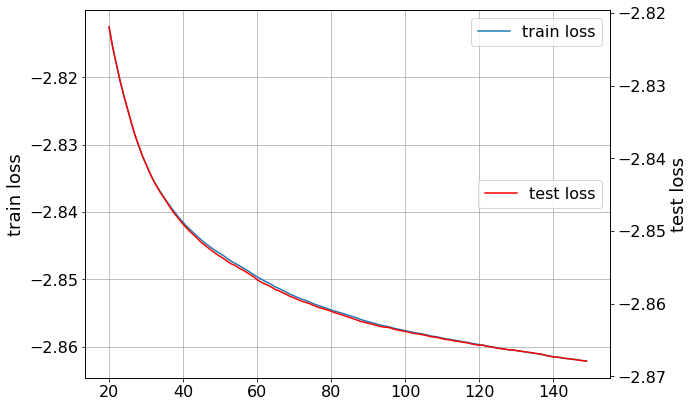

In [25]:
start_with = 20
fig, ax = plt.subplots(figsize=(10,6))
x = list(range(len(history['loss'])))
loss = np.array(history['loss']) / mc_train.shape[0]
test_loss = np.array(history['test_loss']) / mc_test.shape[0]
ax.plot(x[start_with:], loss[start_with:], label='train loss')
ax.set_ylabel('train loss')
ax2 = ax.twinx()
ax2.plot(x[start_with:], test_loss[start_with:], label='test loss', c='r')
ax2.set_ylabel('test loss')
ax.legend(fontsize=16)
ax2.legend(fontsize=16, loc=5)
ax.grid()
fig.tight_layout()

In [27]:
jax.tree_map(np.shape, trained_model.params)

{'Dense_0': {'bias': (16,), 'kernel': (3, 16)},
 'Dense_1': {'bias': (32,), 'kernel': (16, 32)},
 'Dense_2': {'bias': (16,), 'kernel': (32, 16)},
 'Dense_3': {'bias': (1,), 'kernel': (16, 1)}}

In [28]:
weights = onp.array(trained_model(norm_sample))

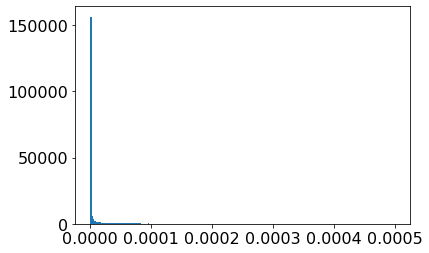

In [29]:
plt.hist(weights, bins=250, range=(0,0.0005));

In [30]:
weights.mean(), weights.std()

(2.922206e-05, 0.00017969166)

In [31]:
weights.flatten().shape, norm_sample[:,0].shape

((200000,), (200000,))

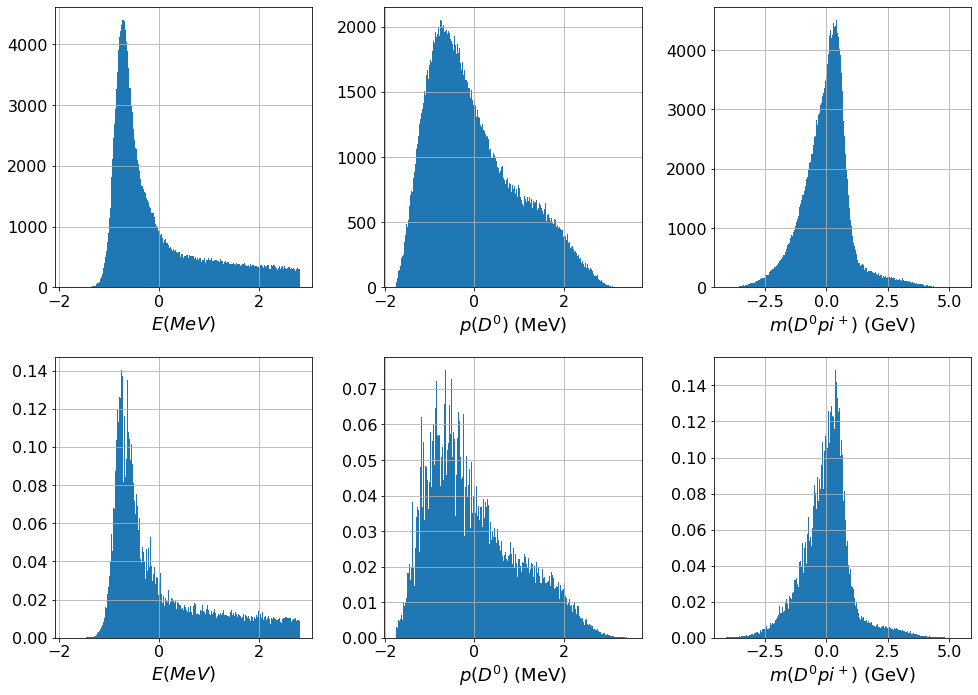

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,10))
draw_1d_projections(ax[0], mc_train)
draw_1d_projections(ax[1], norm_sample, weights=weights.flatten())
fig.tight_layout()

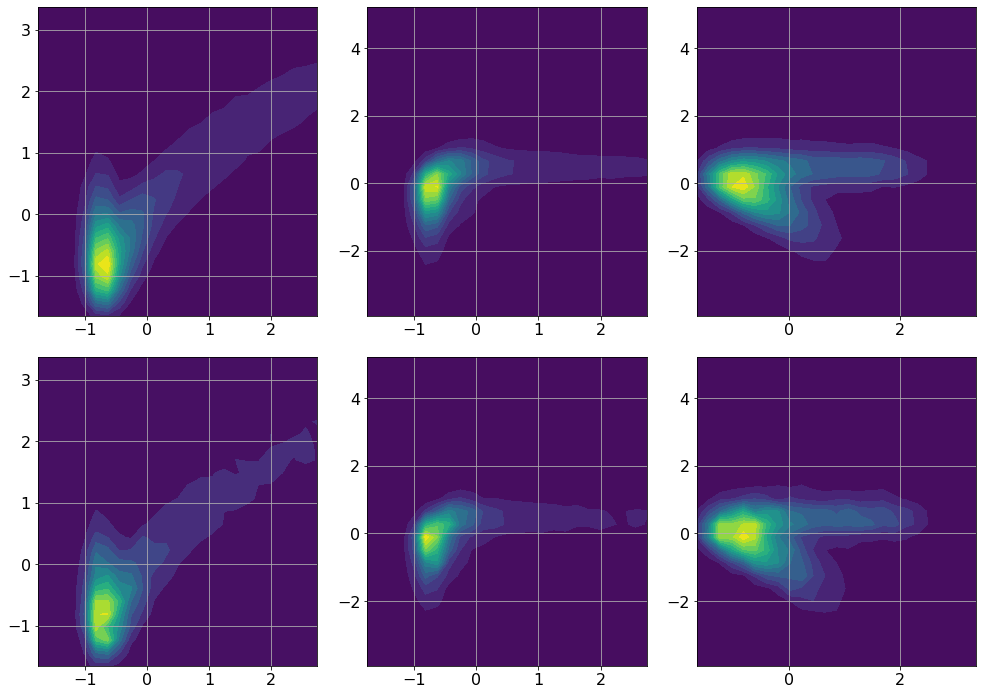

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
draw_2d_projections(ax[0], mc_train, bins=25, levels=15)
draw_2d_projections(ax[1], norm_sample, weights=weights.flatten(), bins=25, levels=15)
fig.tight_layout()

In [34]:
# _, initial_params = NN.init(rjax.PRNGKey(0), data)

In [35]:
# model = nn.Model(NN, initial_params)
#     adam = optim.Adam(learning_rate=0.03)
#     optimizer = adam.create(model)

In [36]:
# with open('nn_model_3d.dat', 'wb') as ofile:
#     state = TrainState(optimizer=optimizer)
#     data = flax.serialization.to_bytes(state)
#     print(f'Model serialized, num bytes: {len(data)}')
#     ofile.write(data)